### Preliminars

##### Imports

In [183]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as iter
%matplotlib widget


##### Misc

In [184]:
np.random.seed(42)


def normalize(points):
    min = points.min(axis=1, keepdims=True)
    scale = points.max(axis=1, keepdims=True) - min
    def denormalize(points): return points * scale + min
    return (points - min) / scale, denormalize

def name_to_int(data):
    names = data.unique()
    name_map = dict(map(reversed, enumerate(names)))
    return data.apply(lambda x: name_map[x]), names

def vectorize(data):
    I = np.identity(np.max(data) + 1)
    return I[:, data]

def set_axis_labels(ax, x, y, z=None):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if z != None:
        ax.set_zlabel(z)


def plot_cluster(X, U, C=None, misses=None,
                title=None, axes_names=None, cluster_names=None):
    C_N = U.shape[0]

    cmap = plt.get_cmap("viridis")
    cnorm = mpl.colors.Normalize(vmin=0, vmax=C_N-1)
    plt.figure()
    title = "Clusters" if title is None else title
    ax = plt.axes(projection="3d", title=title)
    
    U = np.argmax(U, axis=0)
    for c in range(C_N):
        x = np.where(U == c)[0]
        c_name = c if cluster_names is None else cluster_names[c]
        ax.scatter(*X[:3, x], label=c_name, color=cmap(cnorm(c)))
        if misses is not None:
            x = U == c and misses
            ax.scatter(*X[:3, x], color=cmap(cnorm(c)), marker="x")
    
    if axes_names is None:
        axes_names = ["$X_0$", "$X_1$", "$Y_0$"]
    set_axis_labels(ax, *axes_names)
    plt.legend()


### Definitions

##### Norms

In [185]:
norm_names = [
    "Euclidean2",
    "Manhattan",
    "Infinity",
    "Mahalanobis2"
]

norm = dict(zip(norm_names, [
    lambda x: np.sum(x**2, axis=0, keepdims=True),
    lambda x: np.sum(np.abs(x), axis=0, keepdims=True),
    lambda x: np.max(np.abs(x), axis=0, keepdims=True),
    lambda S: lambda x: np.concatenate(
        [c[None, :] @ inv(S) @ c[:, None] for c in x.T])
]))

def dist_matrix(X, Y, norm=norm["Euclidean2"]):
    D = np.zeros((X.shape[1], Y.shape[1]))
    for x, y in iter.product(range(X.shape[1]), range(Y.shape[1])):
        D[x, y] = norm(X[:, x] - Y[:, y])
    return D

##### PDFs

In [186]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x, N):
    return pd.Series(dict(zip(pdf_names, [
        sci.stats.uniform.pdf(x, 0, N),
        sci.stats.triang.pdf(x, 0.5, -1, N+1),
        sci.stats.norm.pdf(x, N//2, N//6)])
    )[pdf], index=x)

##### Learner measures

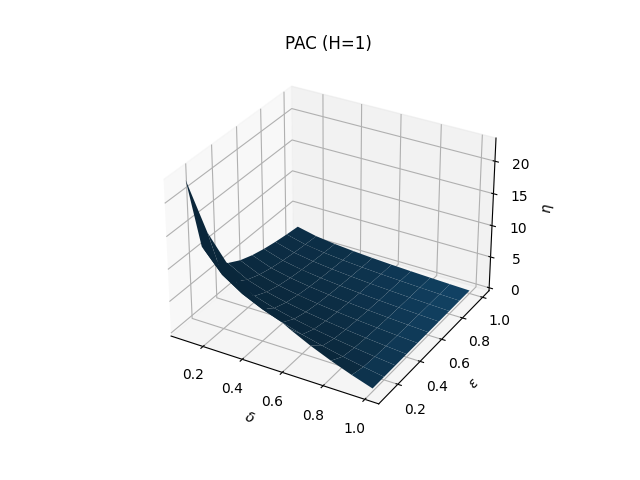

In [187]:



# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.log(H_norm) - np.log(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)

H = 1
plt.figure()
X = Y = np.linspace(0.1, 1, 10)
X, Y = np.meshgrid(X, Y)
ax = plt.axes(projection='3d', title=f'PAC (H={H})')
ax.plot_surface(X, Y, PAC_eta(H, X, Y))
set_axis_labels(ax, '$\\delta$', '$\\varepsilon$', '$\\eta$')
#print(X,Y)


### Data Retrieval

##### Read Data

In [188]:
cluster = True
if cluster:
    file = 'iris.csv'
    index_col, header = 0, 0
else:
    file = 'examen.csv'
    index_col, header = None, None
data = pd.read_csv(file, index_col=index_col, header=header).reset_index(drop=True)
N_S = len(data.index)
indices = data.index
axes_names = data.columns.to_list()

X_S, Y_S = data.iloc[:, :-1], data.iloc[:, -1]
X_S, denormalize_X = normalize(X_S.to_numpy().T)

if cluster:
    Y_S, cluster_names = name_to_int(Y_S)
    Y_S = vectorize(Y_S.to_list())
else:
    Y_S, denormalize_Y = normalize(Y_S.to_numpy().T)


# Sampling

##### Distribution Comparison (PDF)

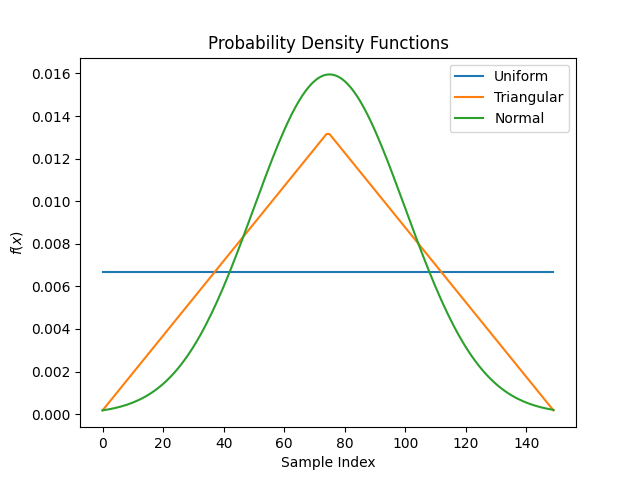

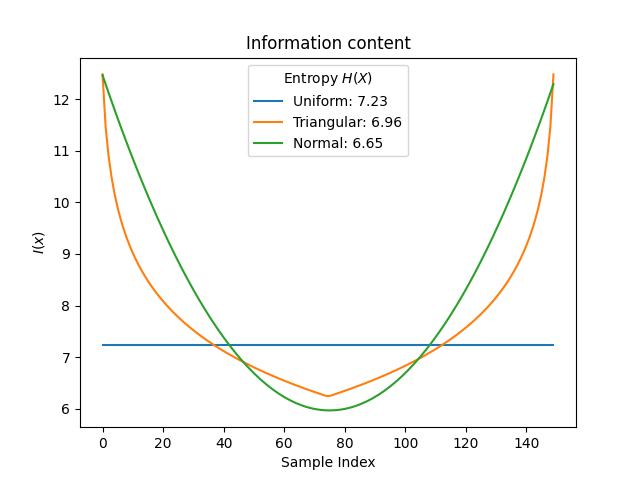

In [189]:
plt.figure()
ax = plt.axes(title="Probability Density Functions")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    ax.plot(indices, F, label=name)
plt.legend()
set_axis_labels(ax, "Sample Index", "$f(x)$")

plt.figure()
ax = plt.axes(title="Information content")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="Entropy $H(X)$")
set_axis_labels(ax, "Sample Index", "$I(x)$")


##### Distribution Comparison (Sample)

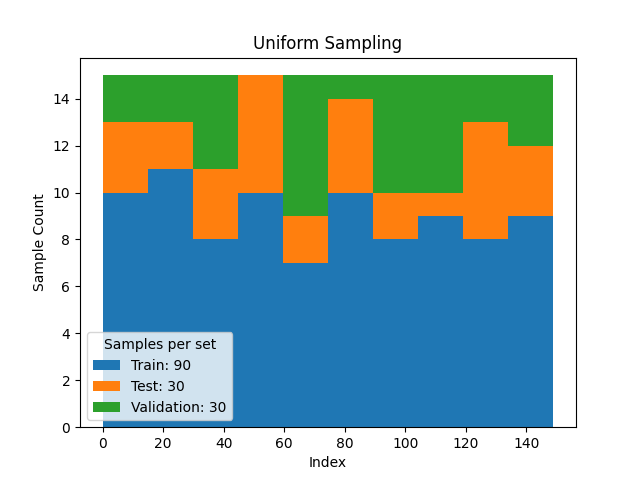

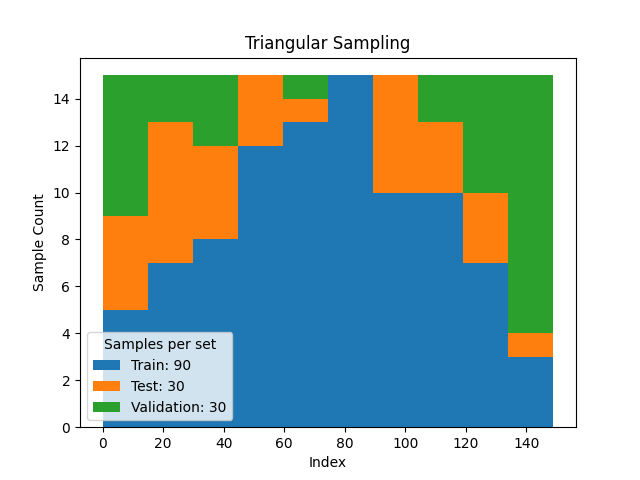

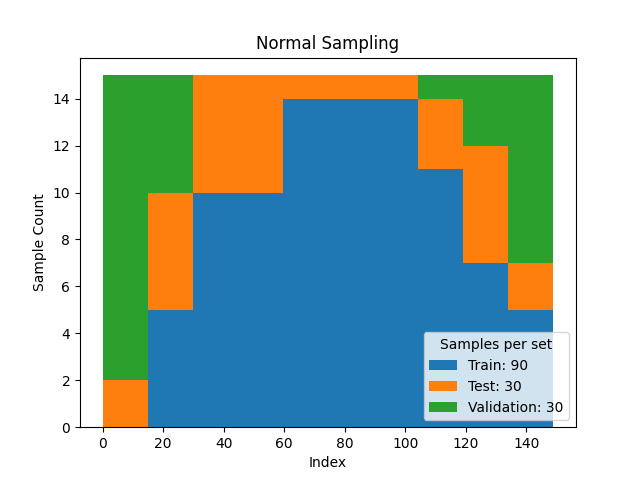

In [190]:
sets = {"Train": int(0.6*N_S),
        "Test": int(0.2*N_S),
        "Validation": int(0.2*N_S)}

sets_S = sets.copy()

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets_curr = sets.copy()
    plt.figure()
    ax = plt.axes(title=f"{name} Sampling")
    
    for k, v in sets_curr.items():
        sample = np.random.choice(weights.index, size=v, p=weights/weights.sum(), replace=False)
        sets_curr[k] = sample
        if name == "Uniform":
            sets_S[k] = (X_S[:, sample], Y_S[:, sample])
        weights = weights.drop(sample)

    ax.hist(sets_curr.values(), stacked=True, bins=10,
        label=[f"{k}: {len(v)}" for k, v in sets_curr.items()]) 
    set_axis_labels(ax, 'Index', 'Sample Count')   
    plt.legend(title="Samples per set")

# Supervised Learning

### Neural Network

##### Definition

In [191]:
def softmax(x): return np.exp(x) / np.sum(np.exp(x), axis=0)
def dsoftmax(x): return softmax(x) * (np.eye(x.shape[0]) - softmax(x).T)
def sigmoid(x): return expit(x)
def dsigmoid(x): return sigmoid(x) * (1 - sigmoid(x))


def feedforward(X, phi, dphi, W, B=None, classify=False, Yd = None, full=False):
    k = len(W) - 1
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        if B != None:
            V[l] += B[l]
        Y[l] = phi(V[l])
    if classify:
        Y[k] = softmax(V[k])
    if Yd is not None:
        dE = Y[k] - Yd
        E = np.average(norm["Euclidean2"](Y[k] - Yd))/2
    if full:
        return Y, V, E, dE
    else:
        return Y[k], E
    

def update(X, Yd, phi, dphi, W, B=None, cluster=False, eta=1):
    p = X.shape[1]
    k = len(W) - 1

    # feedforward
    Y, V, E, dE = feedforward(X,phi, dphi, W, B, cluster, Yd, full=True)
    # backpropagation
    delta = [None] * (k+1)
    if cluster:
        delta[k] = np.concatenate([dsoftmax(V[k][:, [c]]) @ dE[:, [c]]
            for c in range(p)], axis=1)
    else:
        delta[k] = dphi(V[k]) * dE

    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update

    for l in range(1, k+1):
        W[l] -= eta * (delta[l] @ Y[l-1].T) / p
        if B != None:
            B[l] -= eta * (delta[l] @ np.ones((p, 1))) / p
    return delta, E, W, B


##### Run

In [192]:
X, Yd = sets_S["Train"]
X_test, Yd_test = sets_S["Test"]
neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1
epochs = 1000

W = [None] * (k+1)
B = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])
    B[l] = np.random.randn(neurons[l])[:, None]

delta = []
E = {"Train": [],
    "Test": [],
    "Validation": []}
Y_test = []
epochs = 0
delta_curr = np.inf
while epochs < 1000:
    Y_test_curr, E_test_curr = feedforward(
        X_test, sigmoid, dsigmoid, W, B, cluster, Yd_test)
    Y_test.append(Y_test_curr)
    E["Test"].append(E_test_curr)
    
    delta_curr, E_train, W, B = update(X, Yd, sigmoid, dsigmoid, W, B, cluster, 1)
    delta_curr = [np.mean(norm["Euclidean2"](delta_curr[l]))
                     for l in range(1, k+1)]
    delta.append(delta_curr)
    E["Train"].append(E_train)
    epochs += 1


##### Graphs

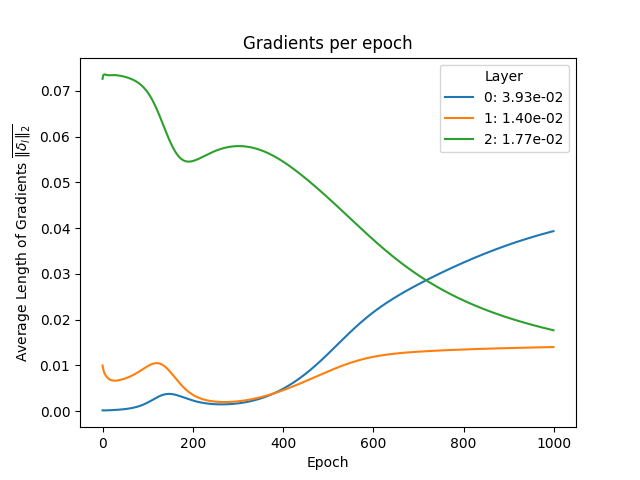

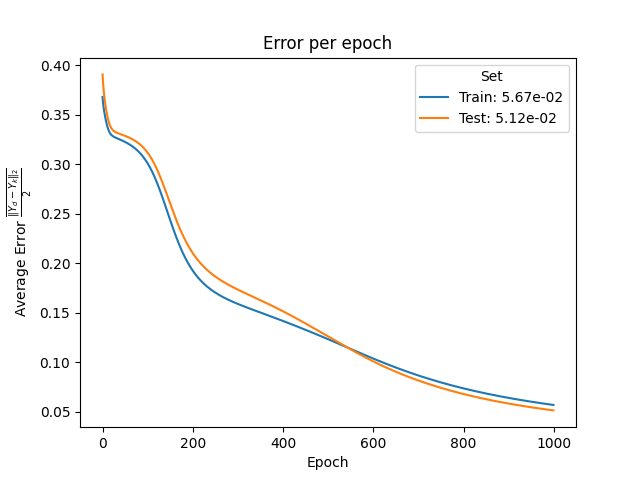

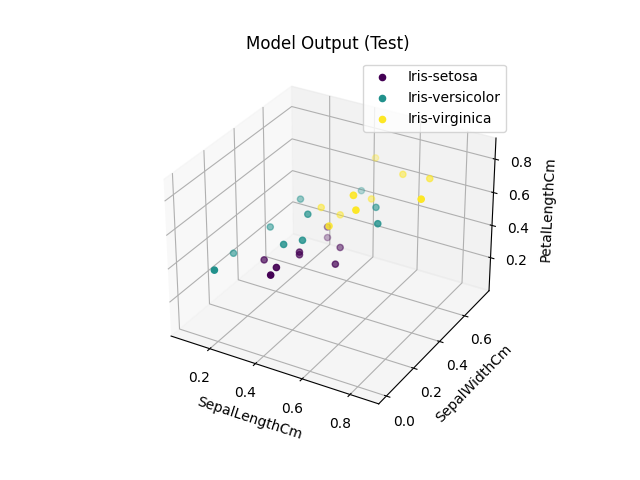

In [193]:
plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
gradients = [f"{l}: {d:.2e}" for l, d in enumerate(delta[-1])]
ax.plot(range(epochs), delta, label=gradients)
ax.legend(title="Layer")
set_axis_labels(ax, "Epoch", 
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), E["Train"], label=f"Train: {E['Train'][-1]:.2e}")
ax.plot(range(epochs), E["Test"], label=f"Test: {E['Test'][-1]:.2e}")
plt.legend(title="Set")
set_axis_labels(ax, "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

if cluster:
    plot_cluster(X_test, Y_test[-1], title="Model Output (Test)",
        cluster_names=cluster_names[:3], axes_names=axes_names[:3])
else:
    plot_N = 11
    ticks = np.linspace(1, len(Y_test), plot_N, dtype=int)
    plt.figure()
    ax = plt.axes(projection="3d", title=f"Output (Test)")
    ax.scatter(*X_test[:2, :], Yd_test, label="Reference", color='darkgreen')
    plt.legend()
    cmap = plt.get_cmap("inferno_r")
    cnorm = mpl.colors.Normalize(vmin=np.min(ticks), vmax=np.max(ticks))
    for c in ticks-1:
        ax.scatter(*X_test[:2, :], Y_test[c][0], color = cmap(cnorm(c)), alpha=0.5)
  
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
    cbar = plt.colorbar(sm, ticks=ticks, ax=ax,
                        location="bottom", label="Epoch")
    set_axis_labels(ax, "$X_0$", "$X_1$", "$Y_0$")


# Unsupervised Learning

### K-means

In [194]:
def cost_intracluster(X, C, norm):
    return np.sum(norm(X-C))


def cost(C, U, X):
    return norm["Euclidean2"](X - C[:, np.argmax(U, axis=0)])

def update_clusters_fuzzy(C, X, m):
    D = dist_matrix(C, X, norm["Euclidean2"])
    U = np.zeros((C.shape[1], X.shape[1]))
    for c in range(C.shape[1]):
        for x in range(X.shape[1]):
            U[c, x] = 1/np.sum((D[c, x]/D[k, x])**(m-1))
    return U
def cost(X, C, norm):
    acum = 0
    for c in range(len(C)):
        acum += cost_intracluster(X[:, C[c][1]], C[c][0], norm)
    return acum


def update_clusters(C, X):
    U = [[] for i in range(C.shape[1])]
    for x, c in enumerate(np.argmin(dist_matrix(C, X), axis=0)):
        U[c].append(x)
    return U

def update_centers(U, X, C):
    C = C.copy()
    for c, u in enumerate(U):
        if len(u) > 0:
            C[:, c] = np.average(X[:, u], axis=1)
    return C


def k_means(k, X, epsilon, epochs):
    U = []
    C_last = X[:, np.random.choice(np.linspace(0, X.shape[1]-1, dtype=int), k)]
    delta = np.inf
    i = 0
    while delta > epsilon and i < epochs:
        U = update_clusters(C_last, X)
        C = update_centers(U, X, C_last)
        delta = np.sum(norm["Euclidean2"](C_last - C))
        C_last = C
        i += 1
    return C_last, update_clusters(C_last, X)

cmap = plt.get_cmap("viridis")
C, U = k_means(3, X, 1e-2, 100)
print(U)
plot_cluster(X, U, C, fuzzy=True)


[[1, 3, 7, 8, 15, 16, 18, 20, 21, 25, 30, 33, 35, 39, 41, 44, 45, 48, 50, 52, 61, 63, 64, 65, 70, 71, 72, 73, 76, 78, 81, 87, 88], [0, 2, 6, 10, 11, 22, 24, 29, 32, 37, 42, 43, 54, 56, 57, 59, 67, 68, 69, 77, 79, 84, 86, 89], [4, 5, 9, 12, 13, 14, 17, 19, 23, 26, 27, 28, 31, 34, 36, 38, 40, 46, 47, 49, 51, 53, 55, 58, 60, 62, 66, 74, 75, 80, 82, 83, 85]]


TypeError: plot_cluster() got an unexpected keyword argument 'fuzzy'

### Fuzzy C-means

In [ ]:
def cost_fuzzy(C, U, X, m):
    J = 0
    for c in range(C.shape[1]):
        for x in range(X.shape[1]):
            J += (U[c, x]**m) * norm["Euclidean2"](X[:, x] - C[:, c])
    return J

def update_centers_fuzzy(U, X, m):
    C = np.zeros((X.shape[0], U.shape[0]))
    for c in range(C.shape[1]):
        C[:, c] = np.sum([(U[c, x]**m) * X[:, x] 
            for x in range(X.shape[1])], axis=1)
        C[:, c] /= np.sum([(U[c, x]**m) 
            for x in range(X.shape[1])])
    return C

def update_clusters_fuzzy(C, X, m):
    D = dist_matrix(C, X, norm["Euclidean2"])
    U = np.zeros((C.shape[1], X.shape[1]))
    for c in range(C.shape[1]):
        for x in range(X.shape[1]):
            U[c, x] = 1/np.sum((D[c, x]/D[k, x])**(m-1))
    return U

def fuzzy_c_means(c, X, m, epsilon):
    # Initialization of membership matrix
    U = np.random.random((c, X.shape[1]))
    for x in X.shape[1]:
        U[:, x] /= np.sum(U[:, x])
    J_last = J = np.inf
    while np.abs(J_last - J) > epsilon:
        C = update_centers_fuzzy(U, X, m)
        J = cost_fuzzy(C, U, X, m)
        if J < epsilon:
            break            
        U = update_clusters_fuzzy(C, X, m)
    return C, U

In [ ]:
data.columns.to_list()


[0, 1, 2, 3, 4]